In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from src import camvid
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline
plt.style.use('dark_background')

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
"""An implementation of Tiramisu auto-encoder for semantic segmentation."""
from keras import backend as K
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import MaxPooling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.regularizers import l2
from src.layers import ContrastNormalization
from src.losses import build_categorical_crossentropy
from src.metrics import metrics_for_segmentation


# batch normalization arguments
_BN = dict(
    beta_regularizer=l2(1e-4),
    gamma_regularizer=l2(1e-4),
)


# static arguments used for all convolution layers in Tiramisu models
_CONV = dict(
    kernel_initializer='he_uniform',
    kernel_regularizer=l2(1e-4),
)


def _dense_block(inputs,
    num_layers: int,
    num_filters: int,
    skip=None,
    dropout: float=0.2
):
    """
    Create a dense block for a given input tensor.

    Args:
        inputs: the input tensor to append this dense block to
        num_layers: the number of layers in this dense block
        num_filters: the number of filters in the convolutional layer
        skip: the skip mode of the dense block as a {str, None, Tensor}
            - 'downsample': the dense block is part of the down-sample side
            - None: the dense block is the bottleneck block bottleneck
            - a skip tensor: the dense block is part of the up-sample side
        dropout: the dropout rate to use per layer (None to disable dropout)

    Returns:
        a tensor with a new dense block appended to it

    """
    # create a placeholder list to store references to output tensors
    outputs = [None] * num_layers
    # if skip is a tensor, concatenate with inputs (upstream mode)
    if K.is_tensor(skip):
        # concatenate the skip with the inputs
        inputs = Concatenate()([inputs, skip])
    # copy a reference to the block inputs for later
    block_inputs = inputs
    # iterate over the number of layers in the block
    for idx in range(num_layers):
        # training=True to compute current batch statistics during inference
        # i.e., during training, validation, and testing
        x = BatchNormalization(**_BN)(inputs, training=True)
        x = Activation('relu')(x)
        x = Conv2D(num_filters, 
            kernel_size=(3, 3), 
            padding='same', 
            use_bias=False, 
            **_CONV
        )(x)
        if dropout is not None:
            x = Dropout(dropout)(x)
        # store the output tensor of this block to concatenate at the end
        outputs[idx] = x
        # concatenate the input with the outputs (unless last layer in block)
        if idx + 1 < num_layers:
            inputs = Concatenate()([inputs, x])

    # concatenate outputs to produce num_layers * num_filters feature maps
    x = Concatenate()(outputs)
    # if skip is 'downstream' concatenate inputs with outputs (downstream mode)
    if skip == 'downstream':
        x = Concatenate()([block_inputs, x])

    return x


def _transition_down_layer(inputs, dropout: float=0.2):
    """
    Create a transition layer for a given input tensor.

    Args:
        inputs: the input tensor to append this transition down layer to
        dropout: the dropout rate to use per layer (None to disable dropout)

    Returns:
        a tensor with a new transition down layer appended to it

    """
    # get the number of filters from the input activation maps
    num_filters = K.int_shape(inputs)[-1]
    # training=True to compute current batch statistics during inference
    # i.e., during training, validation, and testing
    x = BatchNormalization(**_BN)(inputs, training=True)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 
        kernel_size=(1, 1), 
        padding='same', 
        use_bias=False, 
        **_CONV
    )(x)
    if dropout is not None:
        x = Dropout(dropout)(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    return x


def _transition_up_layer(inputs):
    """
    Create a transition up layer for a given input tensor.

    Args:
        inputs: the input tensor to append this transition up layer to

    Returns:
        a tensor with a new transition up layer appended to it

    """
    # get the number of filters from the number of activation maps
    return Conv2DTranspose(K.int_shape(inputs)[-1],
        kernel_size=(3, 3),
        strides=(2, 2),
        padding='same',
        use_bias=False,
        **_CONV
    )(inputs)


def build_tiramisu(
    image_shape: tuple,
    num_classes: int,
    label_names: dict=None,
    class_weights=None,
    initial_filters: int=48,
    growth_rate: int=16,
    layer_sizes: list=[4, 5, 7, 10, 12],
    bottleneck_size: int=15,
    learning_rate: float=1e-3,
    contrast_norm: str='lcn'
) -> Model:
    """
    Build a DenseNet model for the given image shape.

    Args:
        image_shape: the image shape to create the model for
        num_classes: the number of classes to segment for (e.g. c)
        label_names: a dictionary mapping discrete labels to names for IoU
        class_weights: the weights for each class
        initial_filters: the number of filters in the first convolution layer
        growth_rate: the growth rate to use for the network (e.g. k)
        layer_sizes: a list with the size of each dense down-sample block.
                     reversed to determine the size of the up-sample blocks
        bottleneck_size: the number of convolutional layers in the bottleneck
        learning_rate: the learning rate for the RMSprop optimizer
        contrast_norm: the method of contrast normalization for inputs

    Returns:
        a compiled Tiramisu model

    """
    # the input block of the network
    inputs = Input(image_shape, name='Tiramisu_input')
    # assume 8-bit inputs and convert to floats in [0,1]
    x = Lambda(lambda x: x / 255.0, name='pixel_norm')(inputs)
    # apply contrast normalization if set
    if contrast_norm is not None:
        x = ContrastNormalization(method=contrast_norm, name=contrast_norm)(x)
    # the initial convolution layer
    x = Conv2D(initial_filters, 
        kernel_size=(3, 3), 
        padding='same', 
        use_bias=False, 
        **_CONV
    )(x)
    # the down-sampling side of the network (keep outputs for skips)
    skips = [None] * len(layer_sizes)
    # iterate over the size for each down-sampling block
    for idx, size in enumerate(layer_sizes):
        skips[idx] = _dense_block(x, size, growth_rate, skip='downstream')
        x = _transition_down_layer(skips[idx])
    # the bottleneck of the network
    x = _dense_block(x, bottleneck_size, growth_rate)
    # the up-sampling side of the network (using kept outputs for skips)
    for idx, size in reversed(list(enumerate(layer_sizes))):
        x = _transition_up_layer(x)
        x = _dense_block(x, size, growth_rate, skip=skips[idx])
    # the classification block
    x = Conv2D(num_classes, 
        kernel_size=(1, 1), 
        padding='valid', 
        use_bias=False, 
        **_CONV
    )(x)
    x = Activation('softmax')(x)
    # compile the graph
    model = Model(inputs=[inputs], outputs=[x])
    model.compile(
        optimizer=RMSprop(lr=learning_rate),
        loss=build_categorical_crossentropy(class_weights),
        metrics=metrics_for_segmentation(num_classes, label_names, class_weights),
    )

    return model

In [3]:
!mkdir -p models
# the location to save coarse training weights to
coarse_weights = './models/Tiramisu103-CamVid11-coarse3.h5'
# the location to save fine training weights to
fine_weights = './models/Tiramisu103-CamVid11-fine3.h5'

In [4]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Void',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Void',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Void',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Void',
 'TrafficLight': 'Void',
 'Train': 'Car',
 'Tree': 'VegetationMisc',
 'Truck_Bus': 'Car',
 'Tunnel': 'Void',
 'VegetationMisc': 'VegetationMisc',
 'Void': 'Void',
 'Wall': 'Building'}

In [5]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the batch size during coarse training
coarse_batch = 3
# the size to crop images to for fine tune training
fine_crop = (352, 480)
# the batch size during fine training
fine_batch = 1

In [6]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in coarse_crop + fine_crop:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Coarse Tuning

In [7]:
camvid11 = camvid.CamVid(
    mapping=mapping,
    target_size=target_size,
    crop_size=coarse_crop,
    batch_size=coarse_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


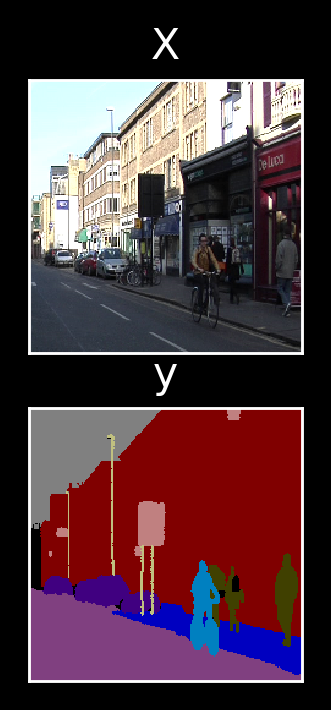

In [8]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [9]:
# build the model for the image shape and number of labels
model = build_tiramisu((*coarse_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    class_weights=(camvid11.class_weights > 0).astype(int),
    contrast_norm=None,
    learning_rate=1e-3,
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 224, 224, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 48) 1296        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [10]:
callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=100),
    LearningRateScheduler(lambda _, lr: 0.995 * lr),
    ModelCheckpoint(coarse_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max'
    ),
    PlotMetrics(),
]

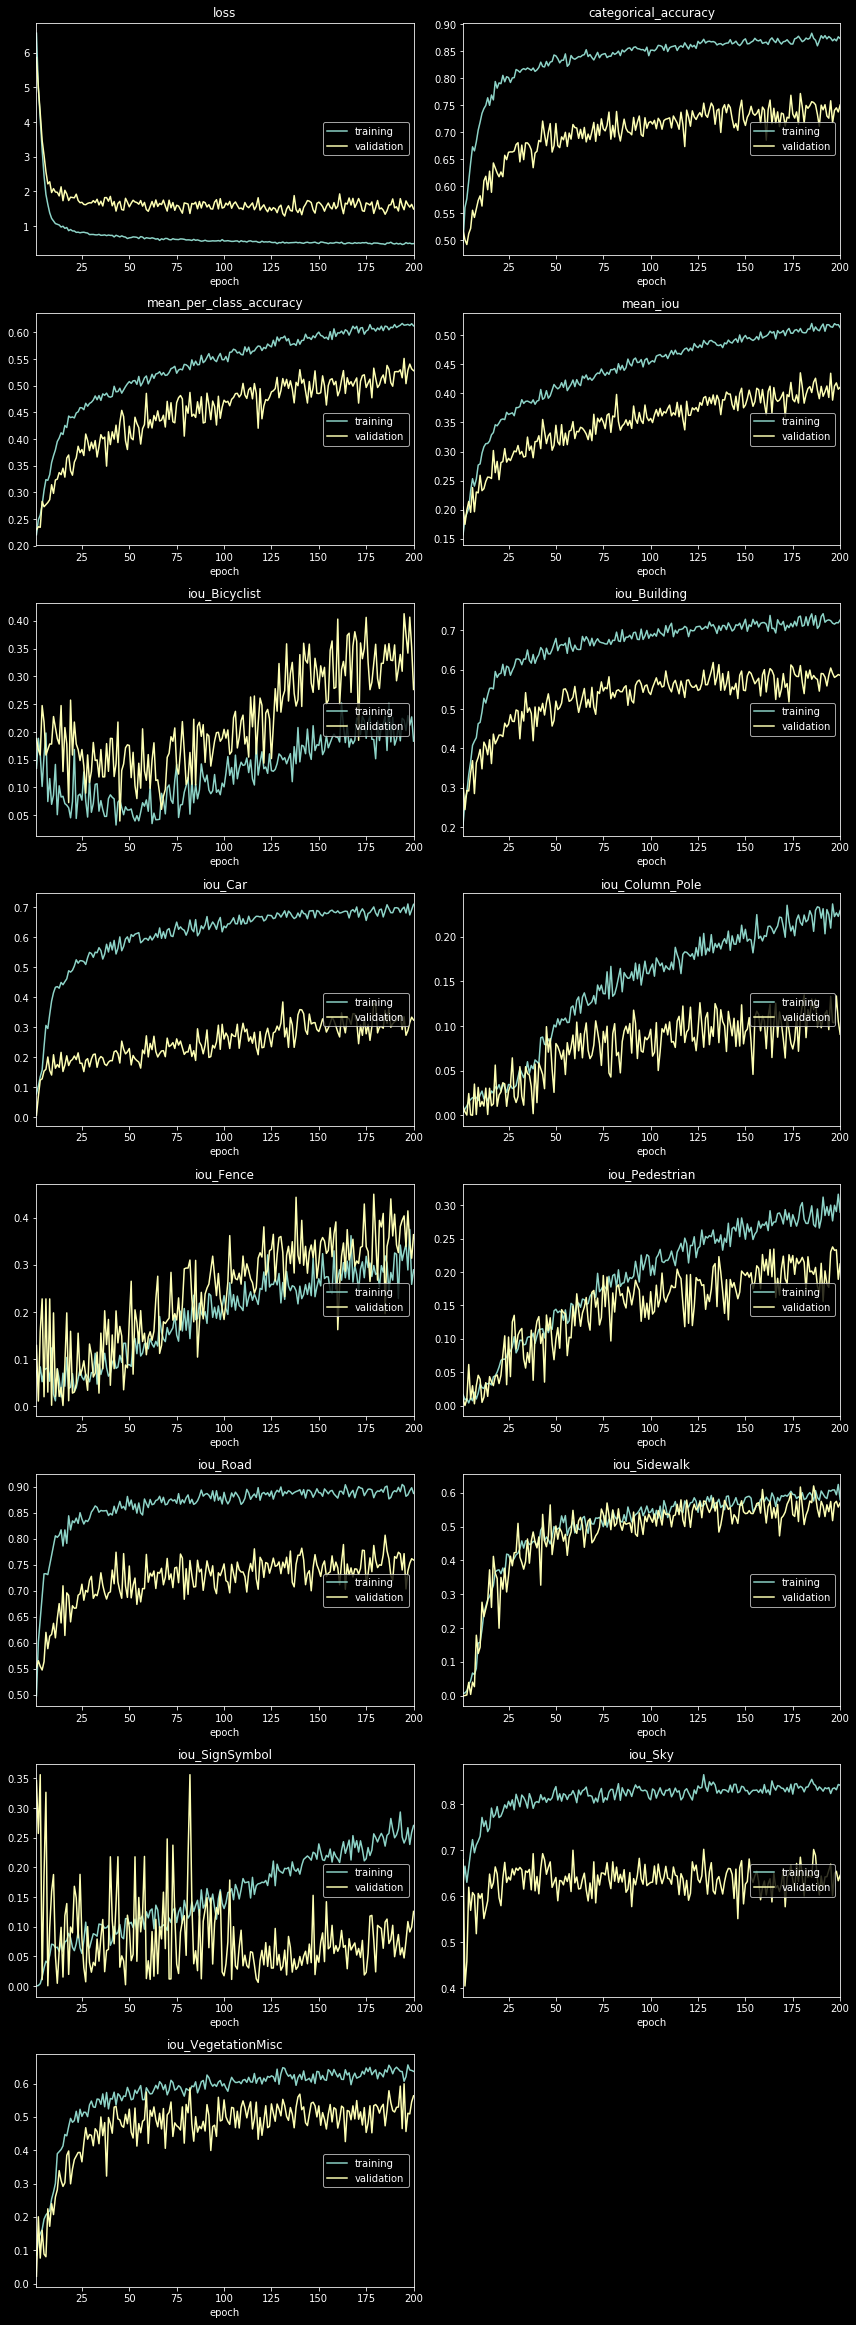

In [11]:
# fit the model with the data. divide the steps per epoch by the batch size
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / coarse_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0
)

In [12]:
history_to_results(history)

train       val
categorical_accuracy     0.873579  0.750416
Bicyclist                0.183412  0.276517
Building                 0.726144  0.585342
Car                      0.709324  0.323631
Column_Pole              0.229284  0.090729
Fence                    0.289405  0.364114
Pedestrian               0.289706  0.212128
Road                     0.887156  0.759039
Sidewalk                 0.579378  0.569820
SignSymbol               0.270734  0.125975
Sky                      0.840739  0.644853
VegetationMisc           0.636707  0.563255
loss                     0.492742  1.492230
mean_iou                 0.512908  0.410491
mean_per_class_accuracy  0.612377  0.528342

## Test Metrics

In [13]:
model.load_weights(coarse_weights)

In [14]:
metrics = model.evaluate_generator(generators['test'], steps=233)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

test
loss                     0.576731
categorical_accuracy     0.852206
mean_per_class_accuracy  0.537513
mean_iou                 0.463930
iou_Bicyclist            0.337936
iou_Building             0.630685
iou_Car                  0.523053
iou_Column_Pole          0.174155
iou_Fence                0.261577
iou_Pedestrian           0.231166
iou_Road                 0.816655
iou_Sidewalk             0.648228
iou_SignSymbol           0.150187
iou_Sky                  0.844582
iou_VegetationMisc       0.485006

## Qualitative Results

In [15]:
def predict(generator):
    X, y = next(generator)
    p = model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p)

### Train

In [16]:
X, y, p = predict(generators['train'])

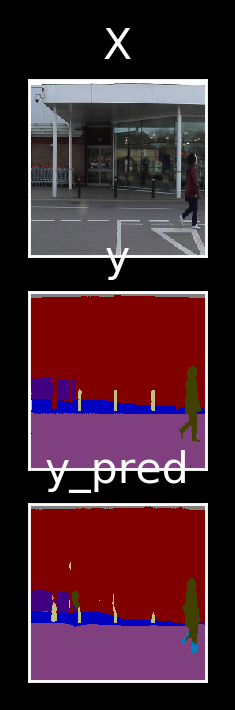

In [17]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

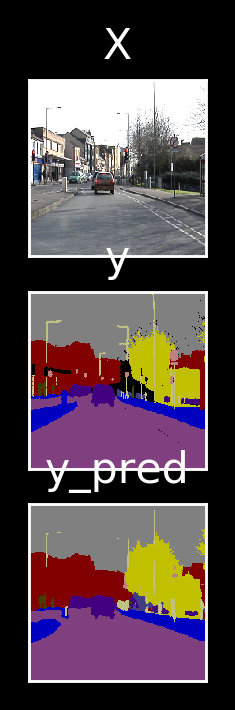

In [18]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1], order=['X', 'y', 'y_pred'])

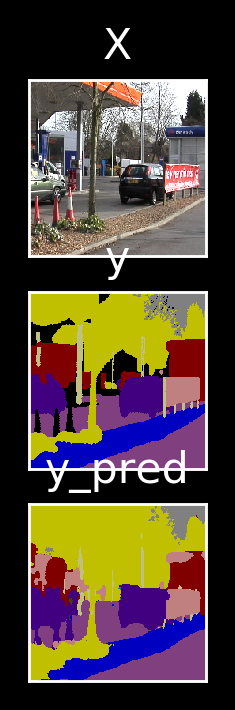

In [19]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2], order=['X', 'y', 'y_pred'])

### Validation

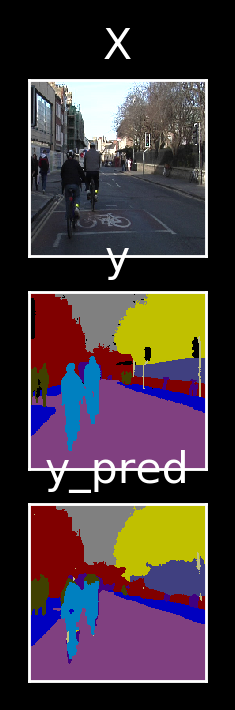

In [20]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

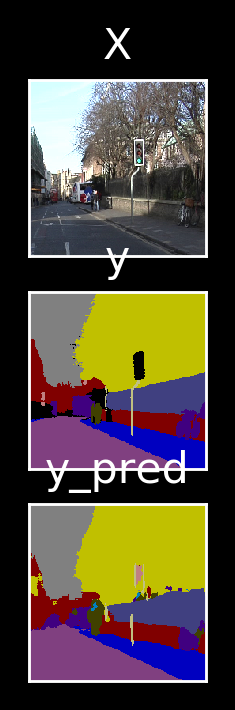

In [21]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

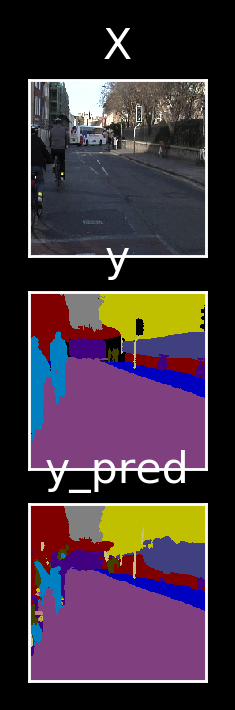

In [22]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

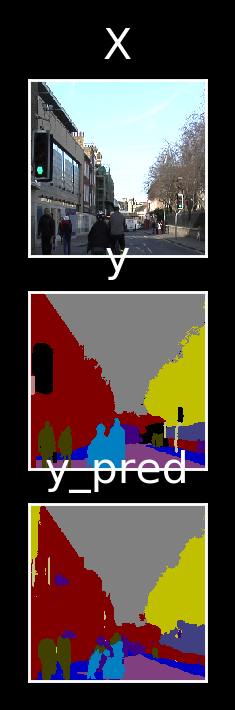

In [23]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

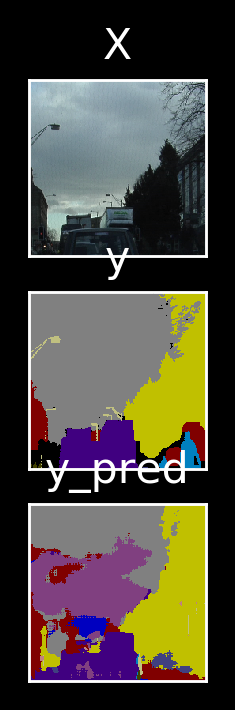

In [24]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

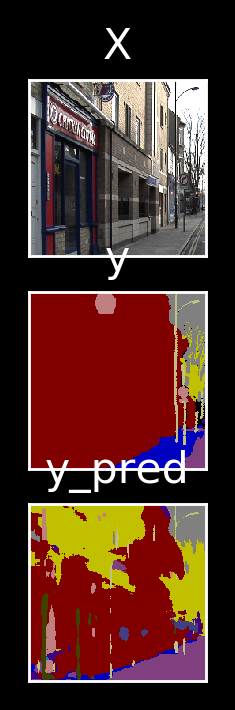

In [25]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

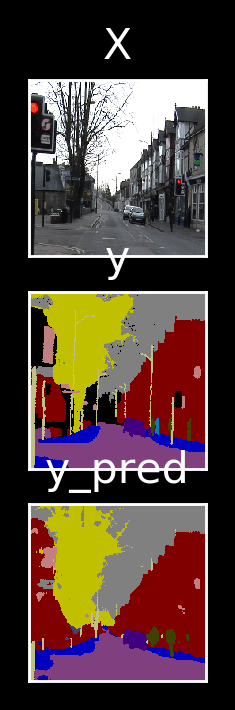

In [26]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

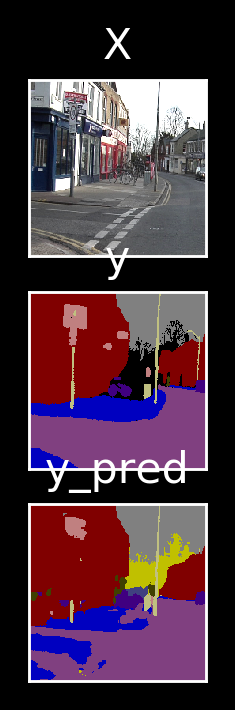

In [27]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

# Clear Session

remove the current model from memory.

In [28]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [29]:
camvid11 = camvid.CamVid(
    mapping=mapping,
    target_size=target_size,
    crop_size=fine_crop,
    batch_size=fine_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


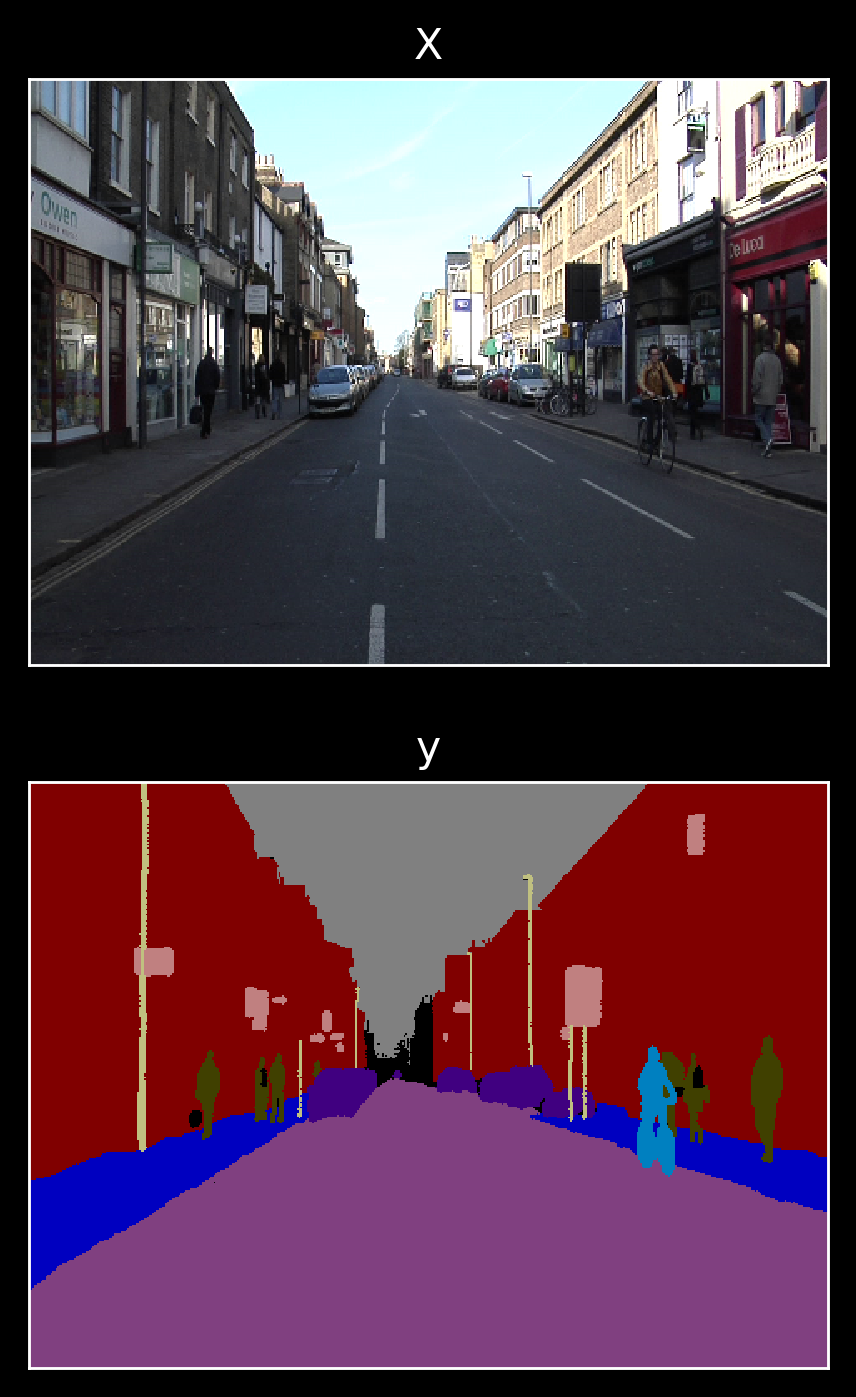

In [30]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [31]:
# build the model for the image shape and number of labels
tune_model = build_tiramisu((*fine_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    class_weights=(camvid11.class_weights > 0).astype(int),
    contrast_norm=None,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights(coarse_weights)
tune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 480, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 480, 48) 1296        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 352, 480, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [32]:
callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=50),
    ModelCheckpoint(fine_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max'
    ),
    PlotMetrics(),
]

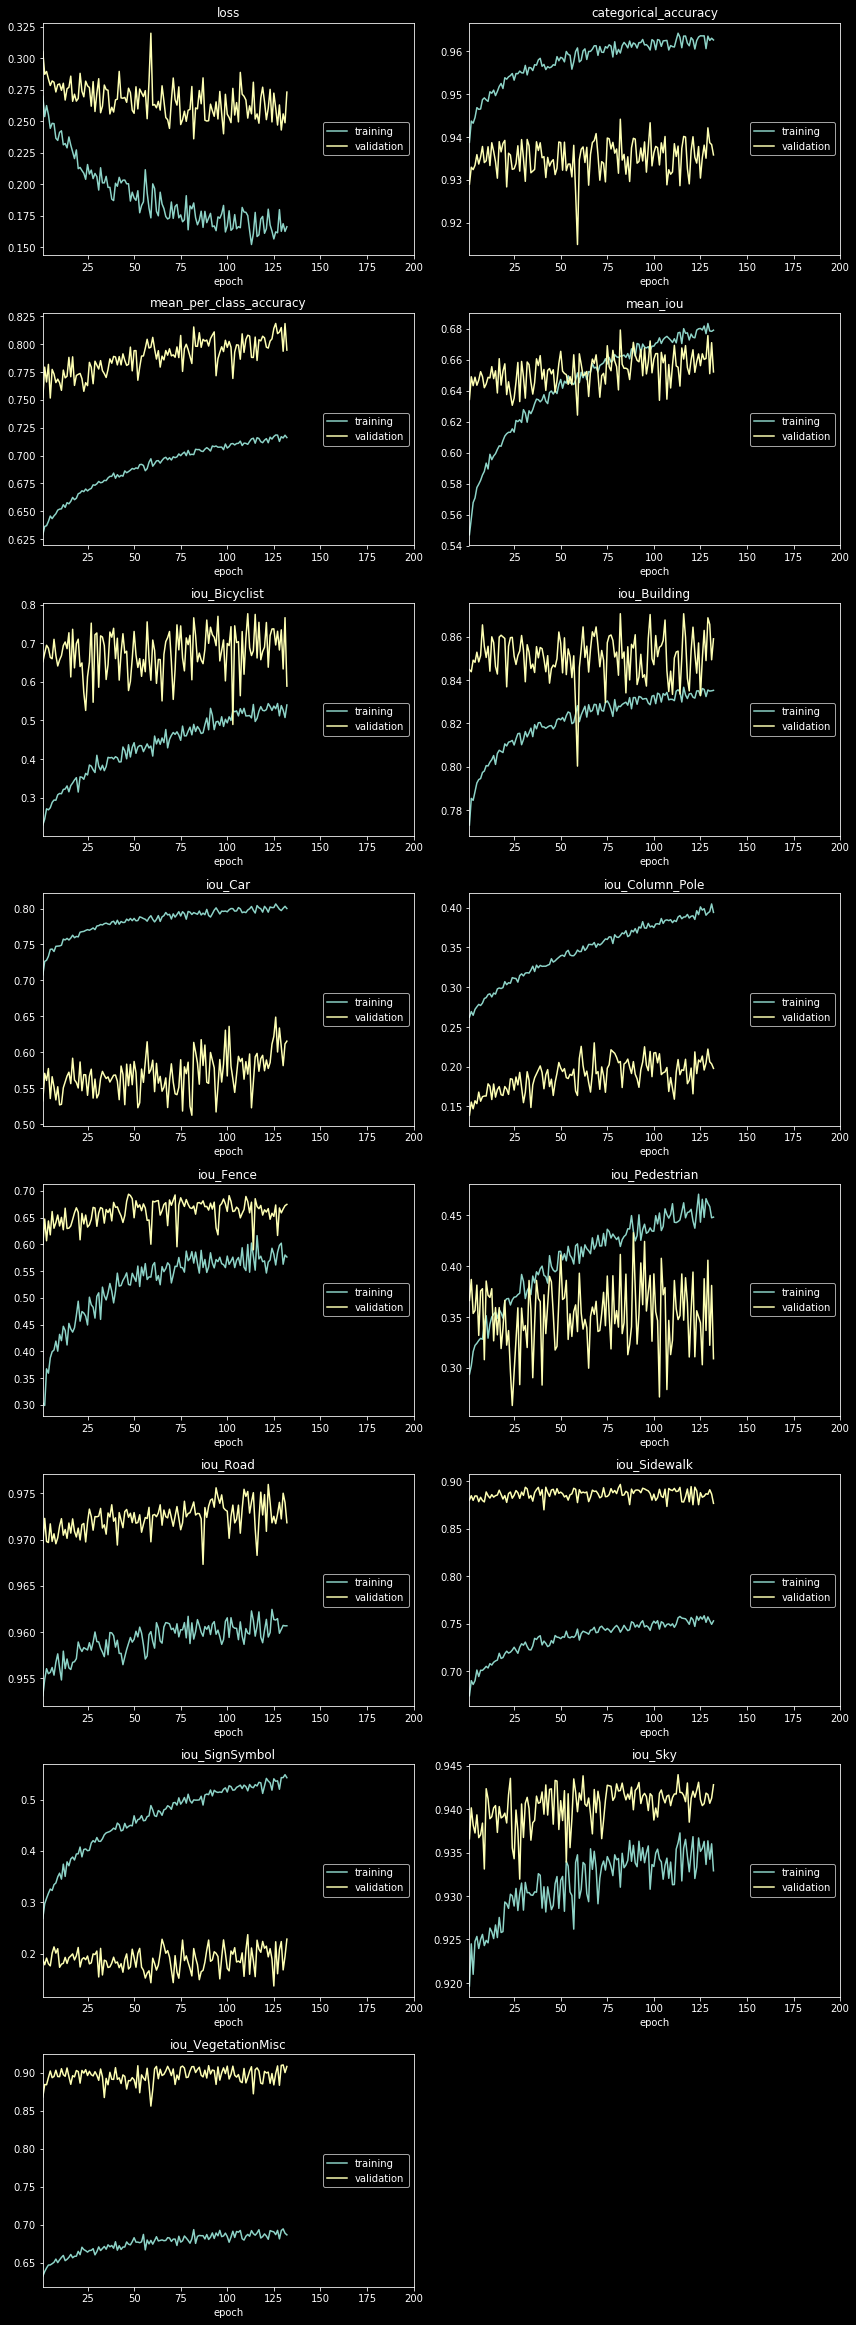

In [33]:
# fit the model with the data.
history = tune_model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / fine_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0,
)

In [34]:
history_to_results(history)

train       val
categorical_accuracy     0.962648  0.935814
Bicyclist                0.540003  0.588740
Building                 0.835247  0.859051
Car                      0.799991  0.615324
Column_Pole              0.394087  0.197903
Fence                    0.576309  0.674642
Pedestrian               0.448104  0.309035
Road                     0.960675  0.971828
Sidewalk                 0.752902  0.876789
SignSymbol               0.542380  0.228547
Sky                      0.932900  0.942793
VegetationMisc           0.686859  0.908331
loss                     0.166207  0.273094
mean_iou                 0.679041  0.652089
mean_per_class_accuracy  0.716128  0.794763

## Test Metrics

In [35]:
tune_model.load_weights(fine_weights)

In [36]:
metrics = tune_model.evaluate_generator(generators['test'], steps=233)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

test
loss                     0.456414
categorical_accuracy     0.893493
mean_per_class_accuracy  0.640664
mean_iou                 0.504989
iou_Bicyclist            0.141645
iou_Building             0.706194
iou_Car                  0.592934
iou_Column_Pole          0.253318
iou_Fence                0.140142
iou_Pedestrian           0.323609
iou_Road                 0.898641
iou_Sidewalk             0.794211
iou_SignSymbol           0.194826
iou_Sky                  0.909046
iou_VegetationMisc       0.600314

## Qualitative Results

In [37]:
def predict(generator):
    X, y = next(generator)
    p = tune_model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p)

### Train

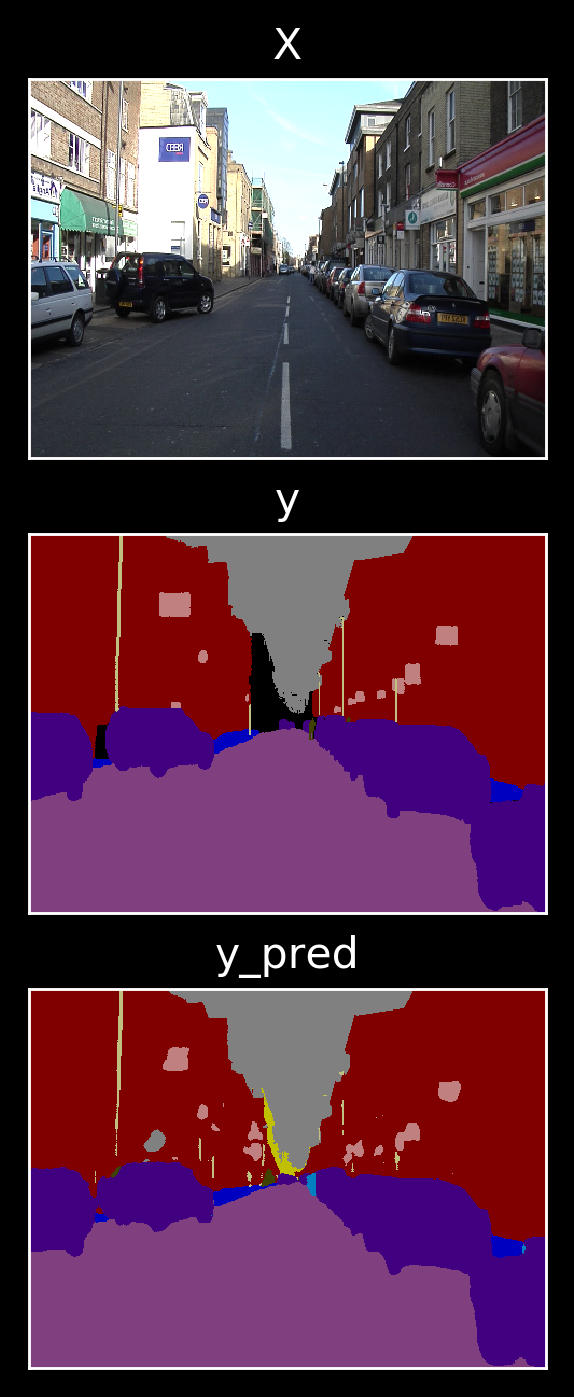

In [38]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

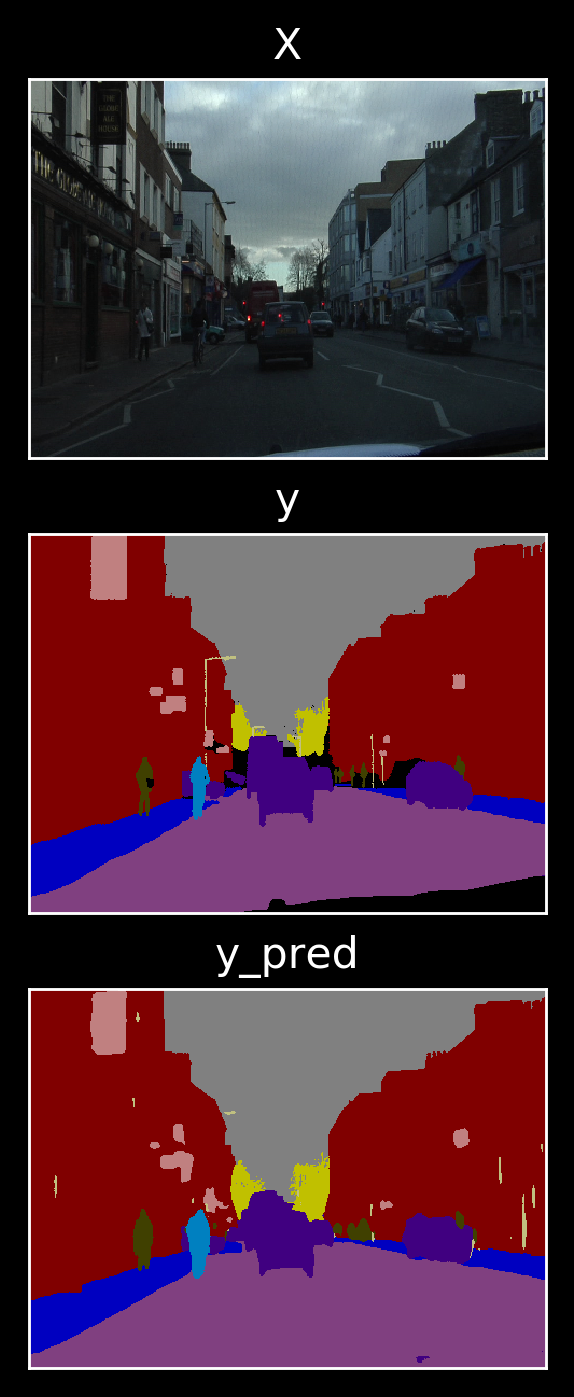

In [39]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

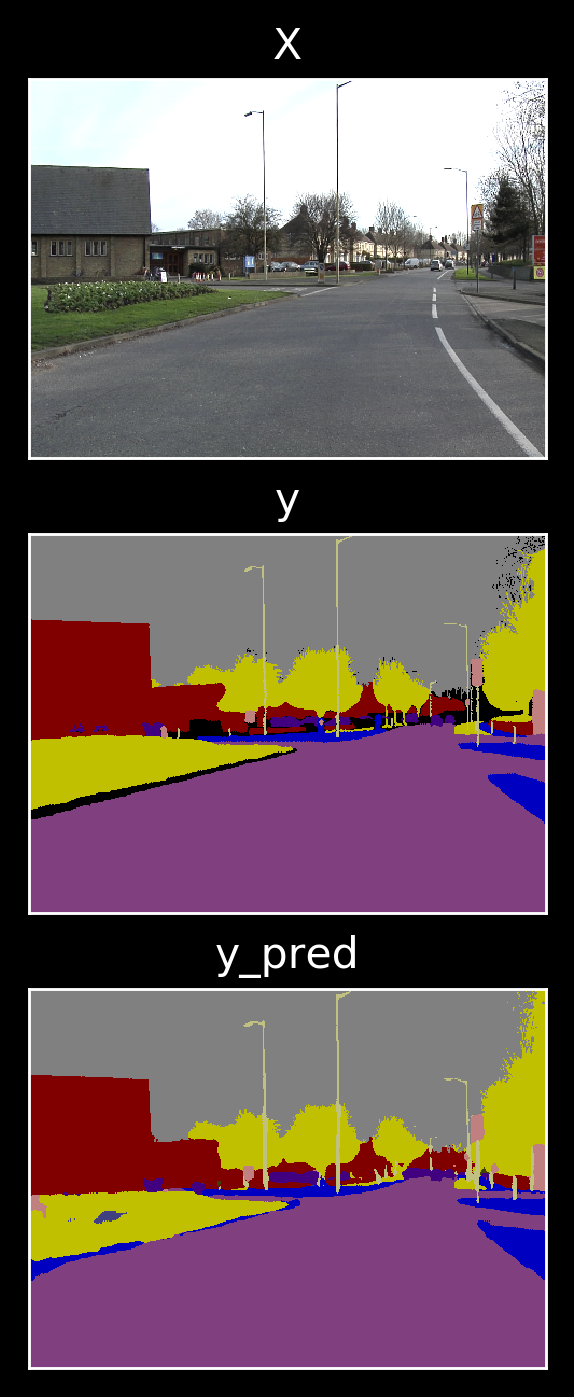

In [40]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

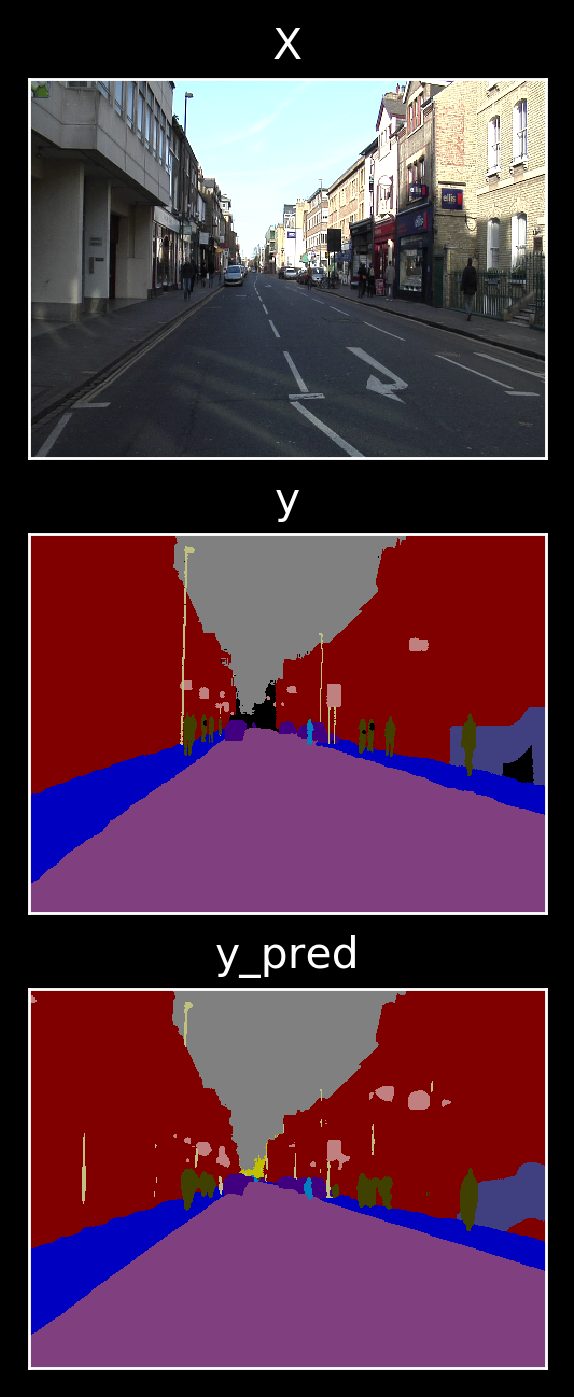

In [41]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Validation

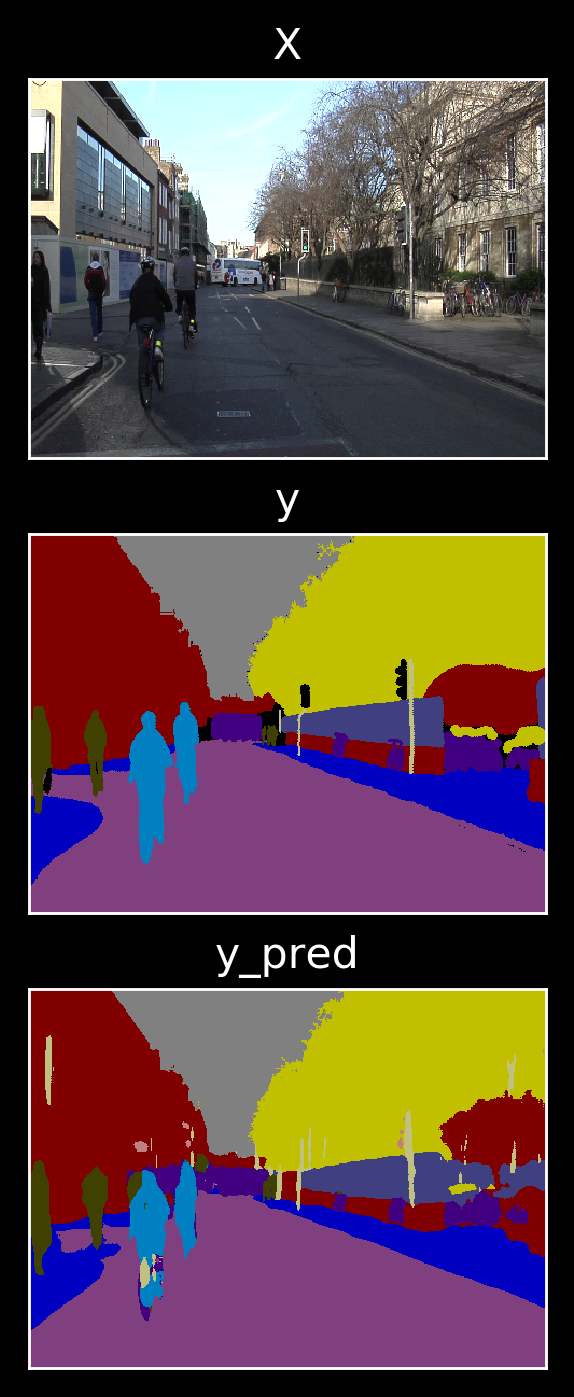

In [42]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

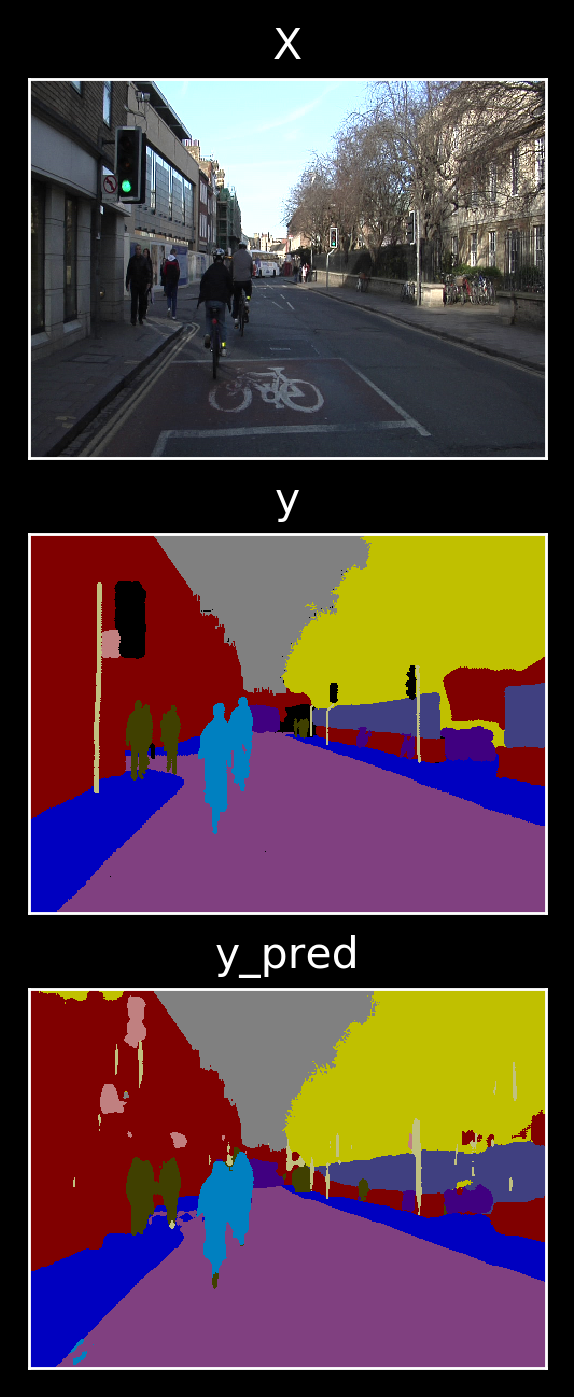

In [43]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

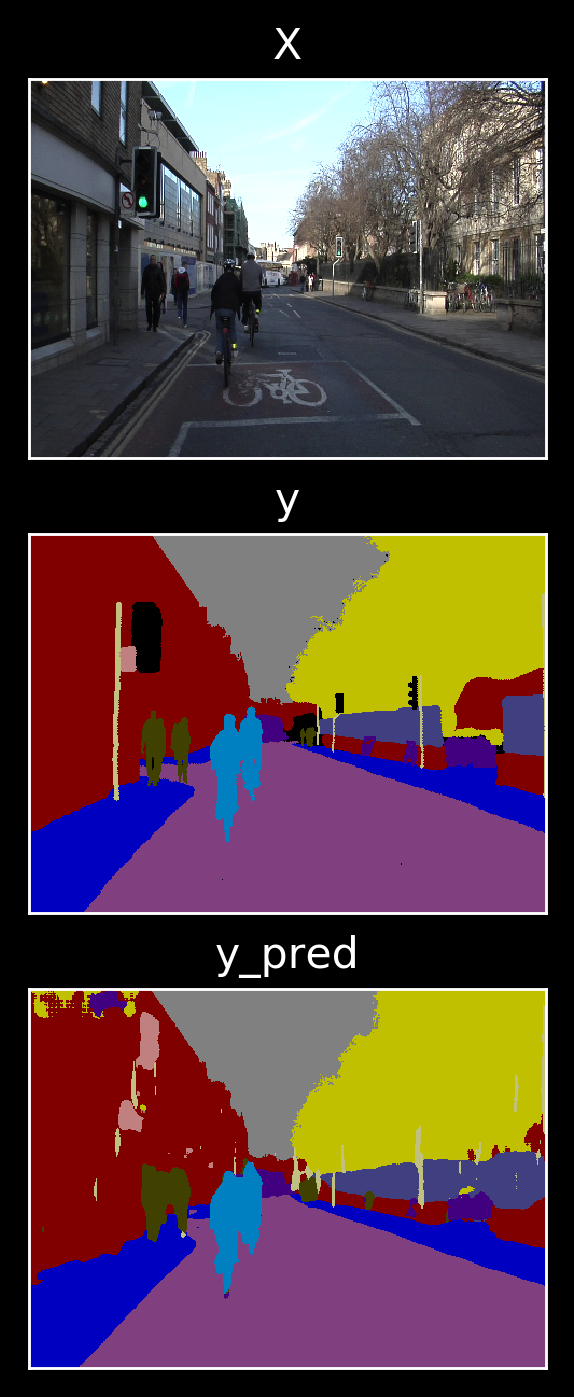

In [44]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

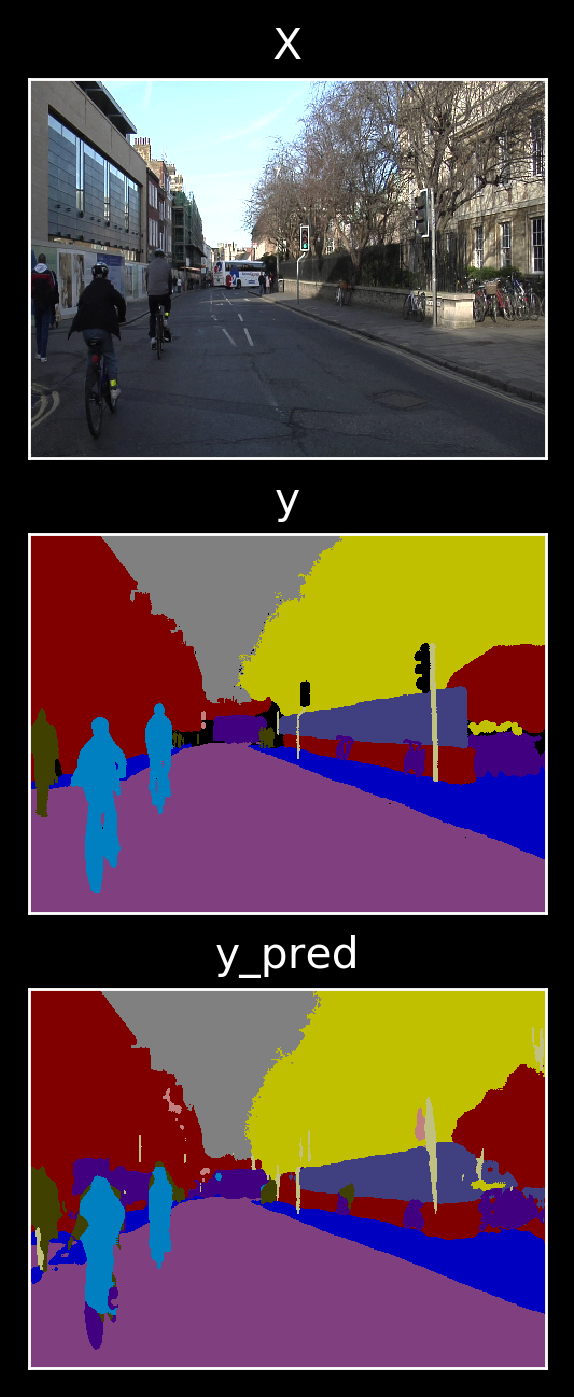

In [45]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

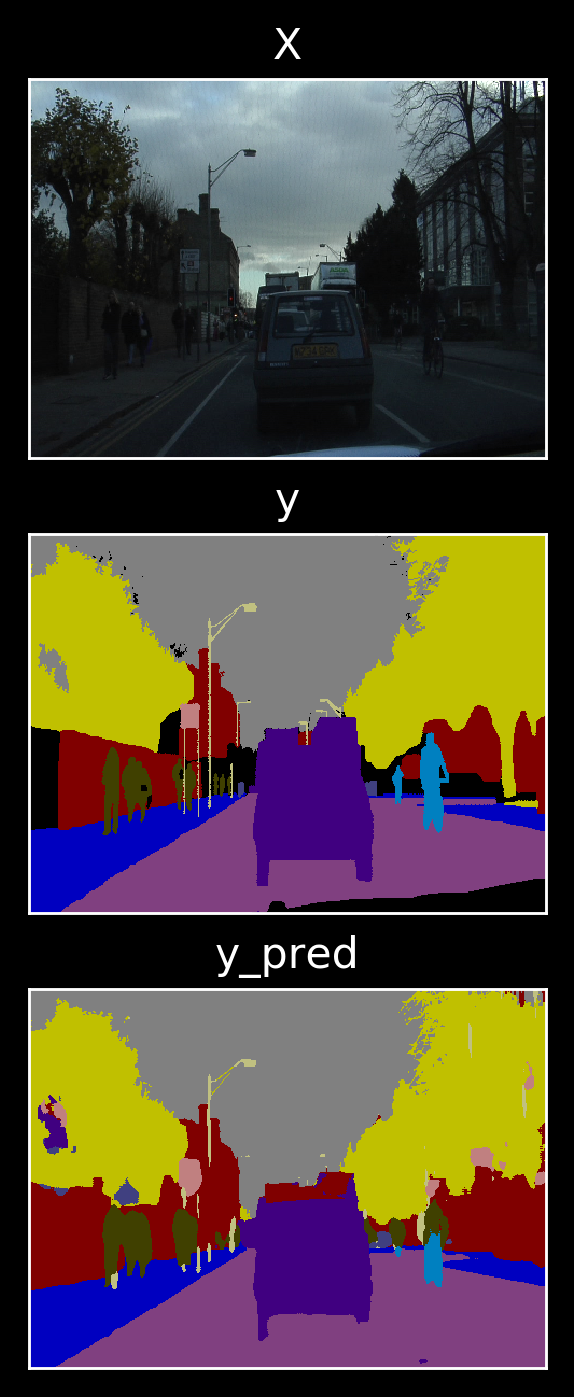

In [46]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

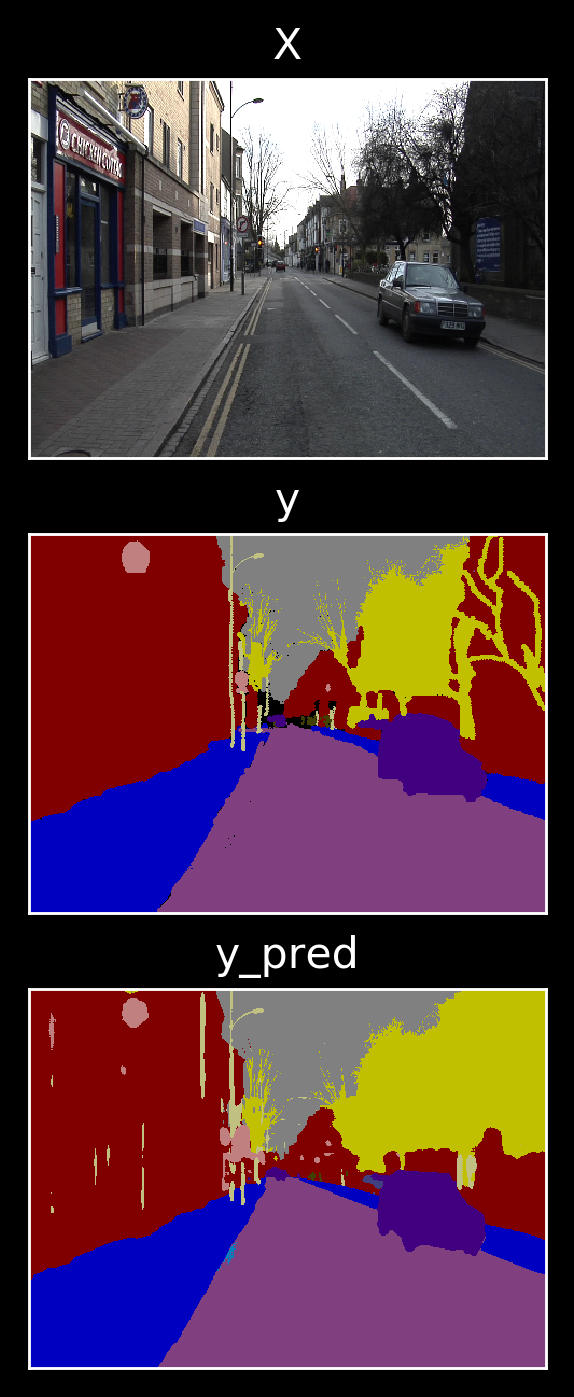

In [47]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

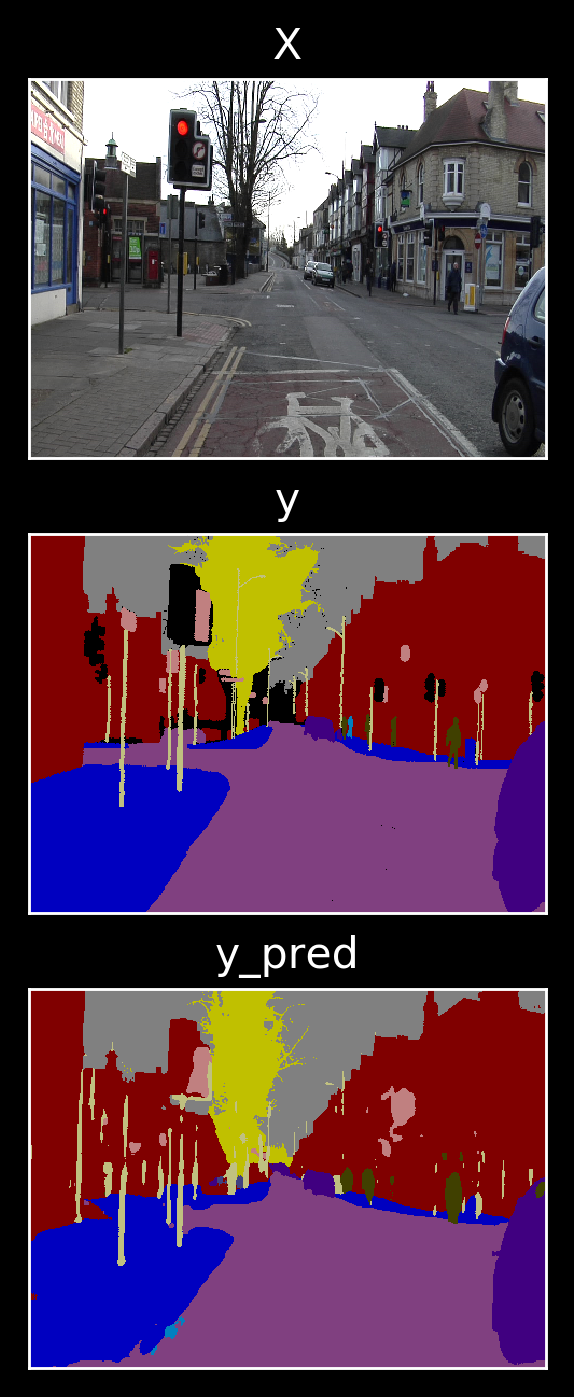

In [48]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

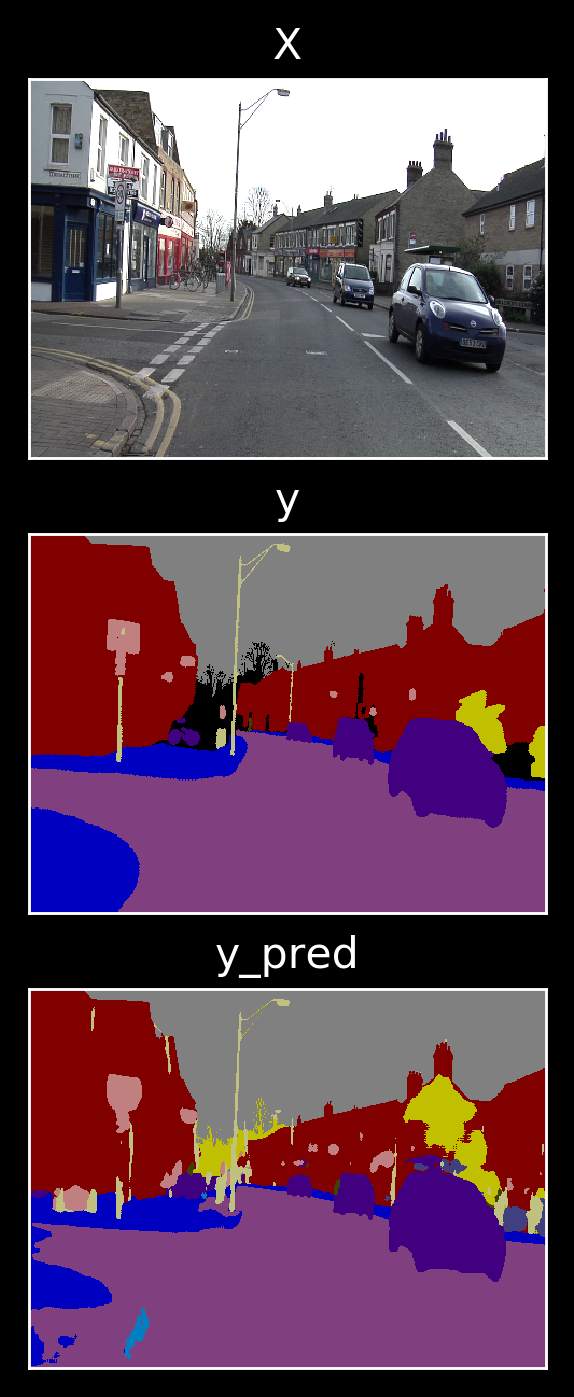

In [49]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])